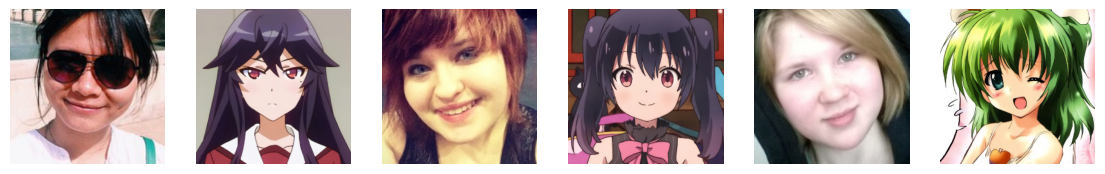

In [9]:
import matplotlib.pyplot as plt
import random
import os

# Create a figure to display images
figure = plt.figure(figsize=(14, 14))
cols, rows = 6, 1  # Number of columns and rows for the subplot
flag = -1  # Flag to alternate between two directories

# Loop to create subplots for images
for i in range(1, cols * rows + 1):
    # Alternate between two image directories based on the flag
    if flag == -1:
        # Get a random image from trainA directory
        lists = os.listdir("./selfie2anime/trainA")
        img = plt.imread("./selfie2anime/trainA/" + lists[random.randint(0, len(lists) - 1)])
    else:
        # Get a random image from trainB directory
        lists = os.listdir("./selfie2anime/trainB")
        img = plt.imread("./selfie2anime/trainB/" + lists[random.randint(0, len(lists) - 1)])
    
    # Add a subplot for the current image
    figure.add_subplot(rows, cols, i)
    flag = -flag  # Toggle the flag for the next iteration
    plt.axis("off")  # Hide the axes
    plt.imshow(img)  # Display the image
# Show the figure with the images
plt.show()

In [7]:
from torch.utils.data import Dataset
import glob
import os
from torchvision import transforms
from PIL import Image, ImageOps
import random
import torch

In [3]:
# Custom dataset class for style transfer
class StyleTransferDataset(Dataset):
    def __init__(self, opt):
        super(StyleTransferDataset, self).__init__()
        self.root = opt.root  # Root directory for the dataset
        self.prob = opt.p  # Probability for applying transformations
        self.input_shape = (opt.input_shape, opt.input_shape)  # Input shape for images
        # Load all image file paths from trainA and trainB directories
        self.content = glob.glob(os.path.join(self.root, 'trainA/*'))
        self.style = glob.glob(os.path.join(self.root, "trainB/*"))

        # Define transformation to convert images to tensors
        self.transform = transforms.ToTensor()

    # Return the number of style images in the dataset
    def __len__(self):
        return len(self.style)

    # Get a style and content image for training
    def __getitem__(self, item):
        # Load a style image from trainB
        style = Image.open(self.style[item]).convert("RGB")
        # Randomly select a content image from trainA
        content = Image.open(random.choice(self.content)).convert("RGB")
        # Resize images to the input shape
        style = ImageOps.fit(style, self.input_shape)
        content = ImageOps.fit(content, self.input_shape)

        # Apply random horizontal flip to the style image based on probability
        p = random.random()
        if p > self.prob:
            style = style.transpose(Image.FLIP_LEFT_RIGHT)

        # Convert images to tensors
        style = self.transform(style)
        content = self.transform(content)

        return style, content  # Return the processed style and content images

    @staticmethod
    def collate(batch):
        styles = []
        contents = []

        # Gather styles and contents into separate lists
        for style, content in batch:
            styles.append(style[None])  # Add a new dimension for batch
            contents.append(content[None])  # Add a new dimension for batch

        # Concatenate all styles and contents along the batch dimension
        return torch.cat(styles, dim=0), torch.cat(contents, dim=0)

In [10]:
import torch.nn as nn

# Define a Residual Block for the ResNet architecture
class ResNetBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResNetBlock, self).__init__()

        # Create a convolutional block consisting of reflection padding, convolution, instance normalization, and ReLU activation
        conv_block = [
            nn.ReflectionPad2d(1),  # Pad input to maintain spatial dimensions
            nn.Conv2d(in_channels=in_channel, out_channels=in_channel, kernel_size=3, stride=1, padding=0),  # Convolution layer
            nn.InstanceNorm2d(in_channel),  # Instance normalization for style transfer
            nn.Identity(),  # Placeholder, no operation
            nn.ReflectionPad2d(1),  # Pad again before the second convolution
            nn.Conv2d(in_channels=in_channel, out_channels=in_channel, kernel_size=3),  # Second convolution layer
            nn.InstanceNorm2d(in_channel),  # Instance normalization
            nn.ReLU(inplace=True)  # ReLU activation
        ]

        # Combine all layers into a sequential model
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        # Forward pass: add input x to the output of the convolutional block (residual connection)
        return self.conv_block(x) + x


# Define the Generator model using the ResNet blocks
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Initial layers of the generator
        net = [
            nn.ReflectionPad2d(3),  # Pad input for the first convolution
            nn.Conv2d(3, 64, 7, 1),  # First convolution layer with 64 output channels
            nn.InstanceNorm2d(64),  # Instance normalization
            nn.ReLU(inplace=True)  # ReLU activation
        ]
        in_channel = 64  # Set initial number of input channels
        
        # Downsampling layers
        net += [
            nn.Conv2d(in_channel, 128, kernel_size=3, stride=2, padding=1),  # Downsample to 128 channels
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downsample to 256 channels
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        ]

        # Add 9 residual blocks
        for i in range(9):
            net += [ResNetBlock(256)]

        # Upsampling layers
        net += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample to 128 channels
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample to 64 channels
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Final layers to output the image
        net += [
            nn.ReflectionPad2d(3),  # Pad for the final convolution
            nn.Conv2d(64, 3, 7, 1),  # Final convolution layer to produce 3 output channels (RGB)
            nn.Tanh()  # Tanh activation to map output values to [-1, 1]
        ]
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*net)

    def forward(self, x):
        # Forward pass through the generator model
        return self.model(x)


# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, attention=False):
        super(Discriminator, self).__init__()
        
        # Initial layers of the discriminator
        model = [
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # Downsample to 64 channels
            nn.Identity(),  # Placeholder, no operation
            nn.LeakyReLU(0.2, inplace=True)  # Leaky ReLU activation
        ]

        # More downsampling layers
        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # Downsample to 128 channels
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # Downsample to 256 channels
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Further downsampling
        model += [
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # Downsample to 512 channels
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Final layer to output a single value (real or fake)
        model += [
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # Output a single channel
        ]
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*model)

    def forward(self, x):
        # Forward pass through the discriminator model
        x = self.model(x)
        return x

In [5]:
def weights_init_normal(m):
    # Initialize weights of a given layer with normal distribution
    classname = m.__class__.__name__  # Get the name of the class of the layer
    if classname.find('Conv') != -1:
        # If the layer is a convolutional layer, initialize weights
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)  # Mean 0, std 0.02
    elif classname.find('BatchNorm2d') != -1:
        # If the layer is a BatchNorm2d layer, initialize weights and biases
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)  # Mean 1, std 0.02
        torch.nn.init.constant_(m.bias.data, 0.0)  # Set bias to 0

def set_weights_init(nets, requires_grad=False):
    # Set the weights initialization for a list of networks
    if not isinstance(nets, list):
        nets = [nets]  # Ensure nets is a list

    for net in nets:
        for param in net.parameters():
            # Set the requires_grad attribute for each parameter
            param.requires_grad_(requires_grad)


In [6]:
class ReplayBuffer():
    def __init__(self, pool_size):
        # Initialize the replay buffer with a specified pool size
        self.pool_size = pool_size  # Maximum number of images to store
        if self.pool_size > 0:  # Create an empty pool if pool size is positive
            self.num_imgs = 0  # Counter for the number of images stored
            self.images = []  # List to hold the images

    def query(self, images):
        # Query the buffer with a list of images
        if self.pool_size == 0:
            # If the pool size is 0, return the input images directly
            return images
        
        return_images = []  # List to hold the returned images
        
        for image in images:
            image = torch.unsqueeze(image.data, 0)  # Add a batch dimension
            if self.num_imgs < self.pool_size:
                # If there's space in the pool, add the image to the pool
                self.num_imgs += 1  # Increment the image count
                self.images.append(image)  # Store the new image
                return_images.append(image)  # Add to the output list
            else:
                # If the pool is full, randomly replace an existing image
                p = random.uniform(0, 1)  # Generate a random probability
                if p > 0.5:
                    # With a probability of 0.5, replace an image in the pool
                    random_id = random.randint(0, self.pool_size - 1)  # Random index
                    tmp = self.images[random_id].clone()  # Clone the existing image
                    self.images[random_id] = image  # Replace with the new image
                    return_images.append(tmp)  # Return the old image
                else:
                    return_images.append(image)  # Just return the new image

        return_images = torch.cat(return_images, 0)  # Concatenate images into a tensor
        return return_images  # Return the batch of images


In [6]:
# Move the Generator model to GPU (if available)
Generator().to("cuda:0")

Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): Identity()
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d

In [7]:
# Move the Discriminator model to GPU (if available)
Discriminator().to("cuda:0")


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Identity()
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [8]:
from torchsummary import summary

# Display the summary of the Generator model with the input shape (3 channels, 224 height, 224 width)
summary(Generator().cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 230, 230]               0
            Conv2d-2         [-1, 64, 224, 224]           9,472
    InstanceNorm2d-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
    InstanceNorm2d-6        [-1, 128, 112, 112]               0
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8          [-1, 256, 56, 56]         295,168
    InstanceNorm2d-9          [-1, 256, 56, 56]               0
             ReLU-10          [-1, 256, 56, 56]               0
  ReflectionPad2d-11          [-1, 256, 58, 58]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
   InstanceNorm2d-13          [-1, 256, 56, 56]               0
         Identity-14          [-1, 256,

In [9]:
# Display the summary of the Discriminator model with the input shape (3 channels, 224 height, 224 width)
summary(Discriminator().cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
          Identity-2         [-1, 64, 112, 112]               0
         LeakyReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4          [-1, 128, 56, 56]         131,200
    InstanceNorm2d-5          [-1, 128, 56, 56]               0
         LeakyReLU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 28, 28]         524,544
    InstanceNorm2d-8          [-1, 256, 28, 28]               0
         LeakyReLU-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 27, 27]       2,097,664
   InstanceNorm2d-11          [-1, 512, 27, 27]               0
        LeakyReLU-12          [-1, 512, 27, 27]               0
           Conv2d-13            [-1, 1, 26, 26]           8,193
Total params: 2,764,737
Trainable param

In [10]:
import numpy as np

class CycleGANTrainer(object):
    def __init__(self, opt, device, dataloader, log_path):
        # Initialize the CycleGAN trainer with options, device, data loader, and log path
        self.opt = opt
        self.device = device
        self.dataloader = dataloader
        
        # Initialize generators and discriminators for both domains
        self.G1 = Generator().to(self.device)
        self.G2 = Generator().to(self.device)
        self.D1 = Discriminator().to(self.device)
        self.D2 = Discriminator().to(self.device)

        # Apply weight initialization to the networks
        self.G1.apply(weights_init_normal)
        self.G2.apply(weights_init_normal)
        self.D1.apply(weights_init_normal)
        self.D2.apply(weights_init_normal)

        # Initialize optimizers for generators and discriminators
        self.opt_G = optim.Adam([{"params": self.G1.parameters()},
                                  {"params": self.G2.parameters()}],
                                lr=self.opt.lr)

        self.opt_D = optim.Adam([{"params": self.D1.parameters()},
                                  {"params": self.D2.parameters()}],
                                lr=self.opt.lr)

        # Define loss functions
        self.loss_MSE = nn.MSELoss()  # Mean Squared Error loss
        self.loss_MAE = nn.L1Loss()   # Mean Absolute Error loss

        # Initialize replay buffers for fake content and style images
        self.fake_content_buffer = ReplayBuffer(50)
        self.fake_style_buffer = ReplayBuffer(50)

    def train_step(self, epoch):
        # Set models to training mode
        self.G1.train()
        self.D1.train()
        self.G2.train()
        self.D2.train()

        # Progress bar for the epoch
        with tqdm(total=len(self.dataloader), desc=f'Epoch {epoch + 1}/{self.opt.epochs}', postfix=dict, mininterval=0.3) as pbar:
            for i, batch in enumerate(self.dataloader):
                # Move batch data to the specified device
                styles, contents = batch[0].to(self.device), batch[1].to(self.device)
                w, h = contents.shape[3], contents.shape[2]  # Get width and height of content images

                # Forward pass through the generators
                G1_style = torch.clamp(self.G1(contents), 0, 1)  # Generate styled content
                recover_content = torch.clamp(self.G2(G1_style), 0, 1)  # Recover content from styled

                G2_content = torch.clamp(self.G2(styles), 0, 1)  # Generate content from styles
                recover_style = torch.clamp(self.G1(G2_content), 0, 1)  # Recover style from content

                # Disable gradient updates for discriminators while updating generators
                set_weights_init([self.D1, self.D2], False)

                self.opt_G.zero_grad()  # Zero gradients for generators

                # Calculate GAN losses for generators
                D2_out_fake = self.D2(G1_style)
                G1_gan_loss = self.loss_MSE(D2_out_fake, torch.ones(D2_out_fake.size()).to(self.device))  # Loss for G1

                D1_out_fake = self.D1(G2_content)
                G2_gan_loss = self.loss_MSE(D1_out_fake, torch.ones(D1_out_fake.size()).to(self.device))  # Loss for G2

                # Combine GAN losses
                Gan_Loss = G1_gan_loss + G2_gan_loss

                # Calculate cycle consistency losses
                Cycle_Loss = self.loss_MAE(contents, recover_content) * 10 + self.loss_MAE(styles, recover_style) * 10

                # Calculate identity losses
                G1_identity = torch.clamp(self.G1(styles), 0, 1)  # Identity mapping for styles
                G2_identity = torch.clamp(self.G2(contents), 0, 1)  # Identity mapping for contents
                Identity_Loss = self.loss_MAE(styles, G1_identity) * 10 * 0.5 + self.loss_MAE(contents, G2_identity) * 10 * 0.5

                # Total loss for the generators
                loss_G = Gan_Loss + Cycle_Loss + Identity_Loss
                loss_G.backward()  # Backpropagate loss
                self.opt_G.step()  # Update generator weights

                # Enable gradient updates for discriminators while updating them
                set_weights_init([self.D1, self.D2], True)
                self.opt_D.zero_grad()  # Zero gradients for discriminators

                # Query the replay buffers for fake images
                content_fake_p = self.fake_content_buffer.query(G2_content)
                style_fake_p = self.fake_style_buffer.query(G1_style)

                # Calculate loss for D1
                D1_out_fake = self.D1(content_fake_p.detach()).squeeze()
                D1_out_real = self.D1(contents).squeeze()
                loss_D11 = self.loss_MAE(D1_out_fake, torch.zeros(D1_out_fake.size()).to(self.device))  # Fake loss
                loss_D12 = self.loss_MAE(D1_out_real, torch.ones(D1_out_real.size()).to(self.device))  # Real loss
                loss_D1 = (loss_D11 + loss_D12) * 0.5  # Average loss for D1

                # Calculate loss for D2
                D2_out_fake = self.D2(style_fake_p.detach()).squeeze()
                D2_out_real = self.D2(styles).squeeze()
                loss_D21 = self.loss_MAE(D2_out_fake, torch.zeros(D2_out_fake.size()).to(self.device))  # Fake loss
                loss_D22 = self.loss_MAE(D2_out_real, torch.ones(D2_out_real.size()).to(self.device))  # Real loss
                loss_D2 = (loss_D21 + loss_D22) * 0.5  # Average loss for D2

                # Total loss for the discriminators
                loss_D = loss_D1 + loss_D2
                loss_D.backward()  # Backpropagate loss for discriminators
                self.opt_D.step()  # Update discriminator weights

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix(**{"loss_D": loss_D.item(),
                                    "loss_G": loss_G.item()})

                # Visualize training progress every 100 batches
                if i % 100 == 0:
                    figure = plt.figure(figsize=(8, 8))
                    cols, rows = 3, 1
                    
                    # Show original content image
                    figure.add_subplot(rows, cols, 1)
                    plt.axis("off")
                    output = np.transpose(contents[0].cpu().clone().detach().numpy(), (1, 2, 0))
                    image = (output * 255.0).astype(np.uint8)
                    image = Image.fromarray(image)
                    image = ImageOps.fit(image, (w, h))
                    plt.imshow(image)

                    # Show generated style image
                    figure.add_subplot(rows, cols, 2)
                    plt.axis("off")
                    output = np.transpose(G1_style[0].cpu().clone().detach().numpy(), (1, 2, 0))
                    image = (output * 255.0).astype(np.uint8)
                    image = Image.fromarray(image)
                    image = ImageOps.fit(image, (w, h))
                    plt.imshow(image)

                    # Show original style image
                    figure.add_subplot(rows, cols, 3)
                    plt.axis("off")
                    output = np.transpose(styles[0].cpu().clone().detach().numpy(), (1, 2, 0))
                    image = (output * 255.0).astype(np.uint8)
                    image = Image.fromarray(image)
                    image = ImageOps.fit(image, (w, h))
                    plt.imshow(image)
                    plt.show()

    def save(self):
        # Save the model checkpoints to the specified directory
        if not os.path.exists(self.opt.save_dir):
            os.mkdir(self.opt.save_dir)  # Create directory if it doesn't exist

        # Prepare checkpoint dictionary
        ckpt = {
            "G1": self.G1.state_dict(),
            "G2": self.G2.state_dict(),
            "D1": self.D1.state_dict(),
            "D2": self.D2.state_dict(),
        }
        print(f"Model has been saved to {os.path.join(self.opt.save_dir, 'model.pth')}")
        torch.save(ckpt, os.path.join(self.opt.save_dir, "model.pth"))  # Save the checkpoint

    def load(self, model_dir):
        # Load model checkpoints from the specified directory
        ckpt = torch.load(model_dir)  # Load the checkpoint
        self.G1.load_state_dict(ckpt["G1"])  # Load G1 weights
        self.G2.load_state_dict(ckpt["G2"])  # Load G2 weights
        self.D1.load_state_dict(ckpt["D1"])  # Load D1 weights
        self.D2.load_state_dict(ckpt["D2"])  # Load D2 weights


In [17]:
from torch.utils.data import DataLoader

def train(opt):
    # Create a log directory for saving experiment logs
    log_path = os.path.join(opt.logs_path, opt.exp_name)
    if not os.path.exists(log_path):
        os.makedirs(log_path)  # Create the directory if it does not exist

    # Set the device to CUDA if available, otherwise use CPU
    device = f"cuda" if torch.cuda.is_available() else "cpu"

    # Initialize the training dataset for style transfer
    train_ds = StyleTransferDataset(opt)
    
    # Create a DataLoader to handle batching and shuffling of the dataset
    train_loader = DataLoader(
        train_ds,                # The dataset to load data from
        batch_size=opt.bs,      # Batch size specified in options
        num_workers=0,          # Number of subprocesses to use for data loading (set to 0 for simplicity)
        shuffle=True,           # Shuffle the dataset at every epoch
        collate_fn=StyleTransferDataset.collate  # Custom collate function for batching
    )

    # Initialize the CycleGAN trainer with options, device, and data loader
    cyclegantrainer = CycleGANTrainer(opt, device, train_loader, log_path)

    # If pretraining is enabled, load the model from the specified directory
    if opt.pretrain:
        cyclegantrainer.load(opt.model_dir)

    # Start the training process for the specified number of epochs
    for epoch in range(opt.epochs):
        cyclegantrainer.train_step(epoch)  # Perform a training step for the current epoch
        cyclegantrainer.save()              # Save the model state after each epoch


Epoch 1/1:   0%|                                            | 1/3400 [00:00<27:28,  2.06it/s, loss_D=1.04, loss_G=3.52]

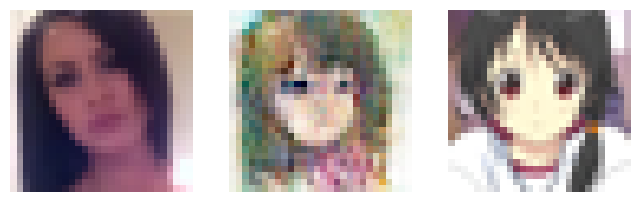

Epoch 1/1:   3%|█▏                                       | 101/3400 [00:43<22:11,  2.48it/s, loss_D=0.776, loss_G=3.56]

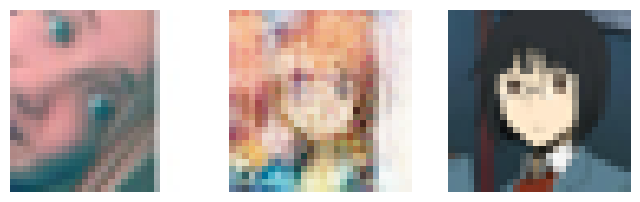

Epoch 1/1:   6%|██▍                                      | 201/3400 [01:04<10:49,  4.93it/s, loss_D=0.537, loss_G=3.32]

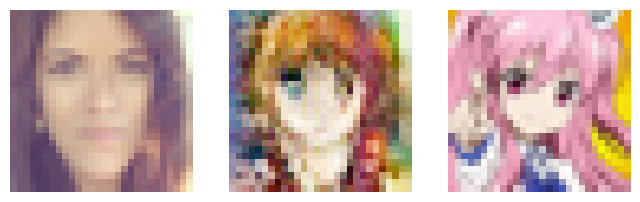

Epoch 1/1:   9%|███▋                                     | 301/3400 [01:27<12:11,  4.23it/s, loss_D=0.726, loss_G=3.87]

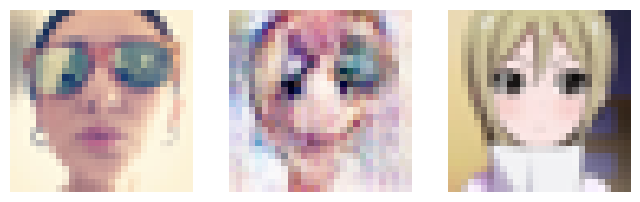

Epoch 1/1:  12%|████▊                                    | 401/3400 [01:49<09:47,  5.11it/s, loss_D=0.866, loss_G=3.23]

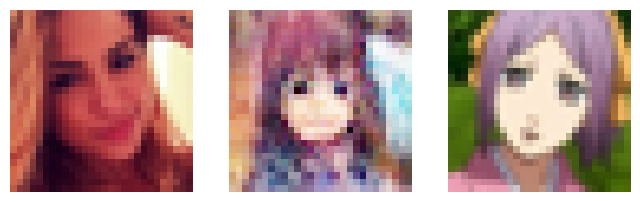

Epoch 1/1:  15%|██████▏                                   | 501/3400 [02:09<09:24,  5.14it/s, loss_D=1.13, loss_G=3.09]

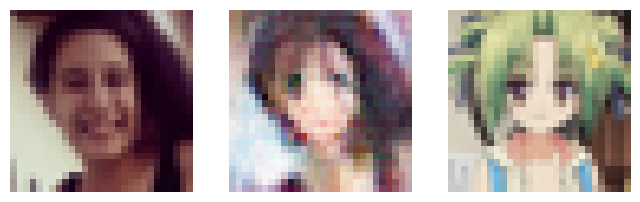

Epoch 1/1:  18%|███████▏                                 | 601/3400 [02:30<09:51,  4.73it/s, loss_D=0.925, loss_G=3.81]

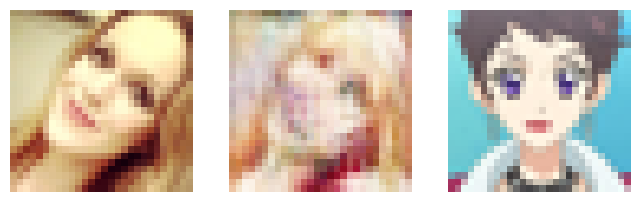

Epoch 1/1:  21%|████████▋                                 | 701/3400 [02:56<10:43,  4.20it/s, loss_D=0.72, loss_G=2.92]

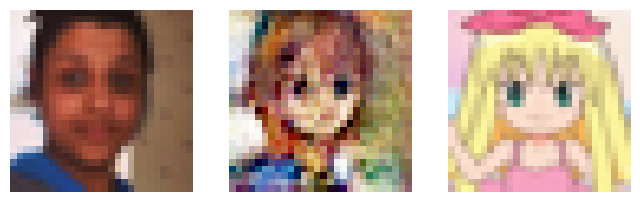

Epoch 1/1:  24%|█████████▉                                | 801/3400 [03:17<09:08,  4.74it/s, loss_D=1.11, loss_G=3.48]

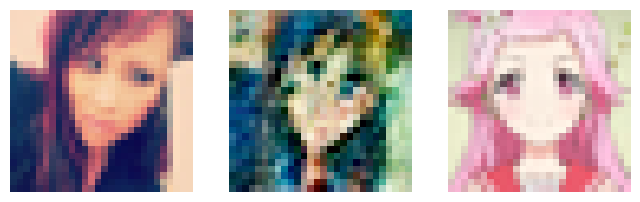

Epoch 1/1:  26%|██████████▊                              | 901/3400 [03:38<08:05,  5.15it/s, loss_D=0.755, loss_G=2.83]

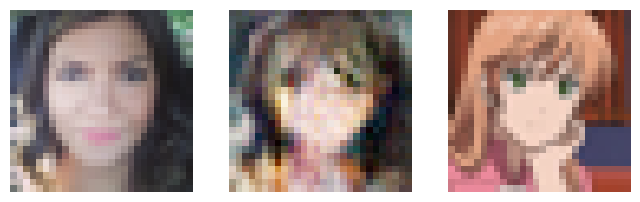

Epoch 1/1:  29%|████████████▎                             | 1001/3400 [03:57<07:48,  5.12it/s, loss_D=0.61, loss_G=3.4]

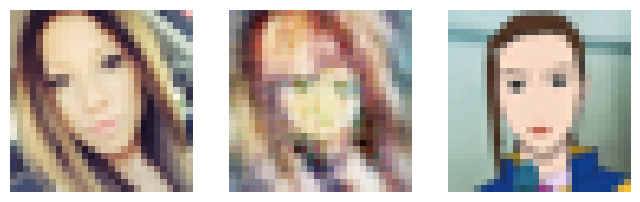

Epoch 1/1:  32%|████████████▉                           | 1101/3400 [04:18<07:55,  4.83it/s, loss_D=0.634, loss_G=3.57]

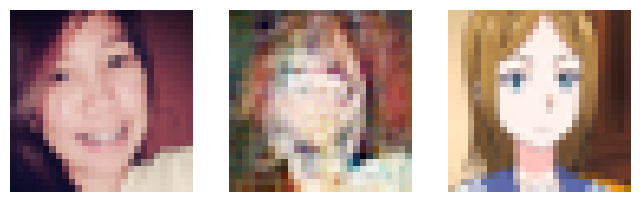

Epoch 1/1:  35%|██████████████▏                         | 1201/3400 [04:41<07:33,  4.85it/s, loss_D=0.651, loss_G=3.33]

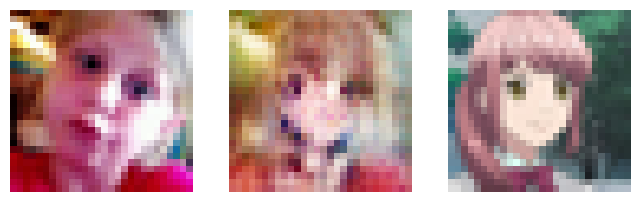

Epoch 1/1:  38%|███████████████▎                        | 1301/3400 [05:04<06:42,  5.22it/s, loss_D=0.622, loss_G=3.54]

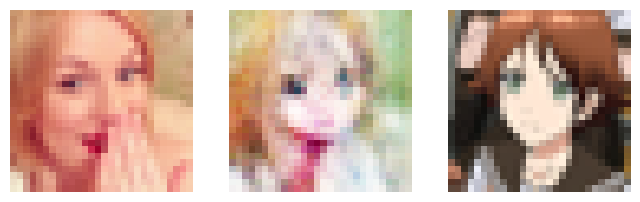

Epoch 1/1:  41%|████████████████▍                       | 1401/3400 [05:23<06:19,  5.27it/s, loss_D=0.855, loss_G=4.96]

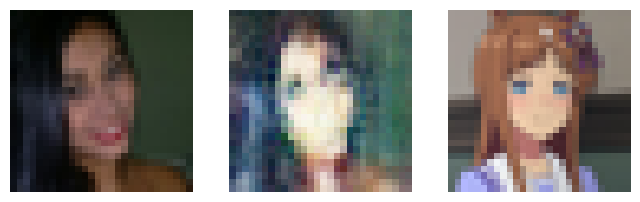

Epoch 1/1:  44%|█████████████████▋                      | 1501/3400 [05:43<06:18,  5.02it/s, loss_D=0.776, loss_G=3.18]

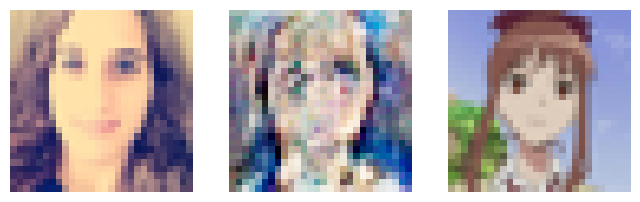

Epoch 1/1:  47%|██████████████████▊                     | 1601/3400 [06:02<06:18,  4.75it/s, loss_D=0.547, loss_G=3.83]

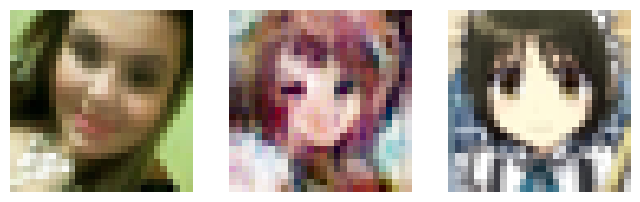

Epoch 1/1:  50%|████████████████████▌                    | 1701/3400 [06:22<05:24,  5.24it/s, loss_D=0.47, loss_G=3.49]

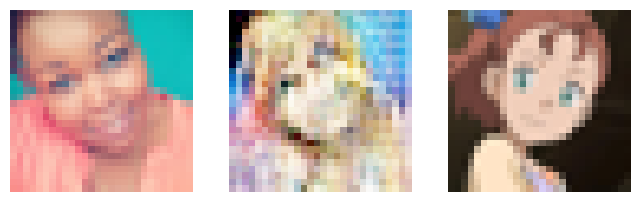

Epoch 1/1:  53%|█████████████████████▏                  | 1801/3400 [06:41<05:09,  5.17it/s, loss_D=0.761, loss_G=4.03]

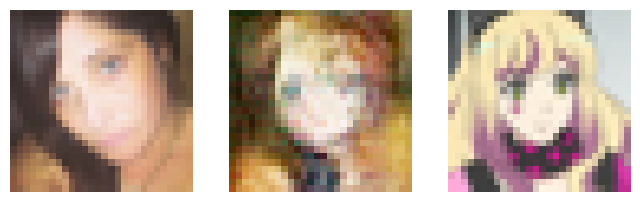

Epoch 1/1:  56%|██████████████████████▎                 | 1901/3400 [07:02<05:04,  4.92it/s, loss_D=0.396, loss_G=4.32]

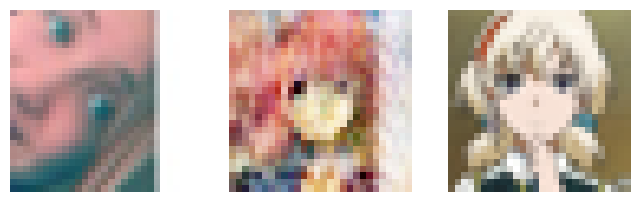

Epoch 1/1:  59%|███████████████████████▌                | 2001/3400 [07:27<05:41,  4.10it/s, loss_D=0.897, loss_G=3.05]

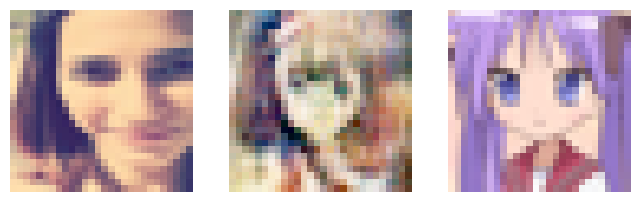

Epoch 1/1:  62%|█████████████████████████▎               | 2101/3400 [07:48<04:07,  5.24it/s, loss_D=1.05, loss_G=3.49]

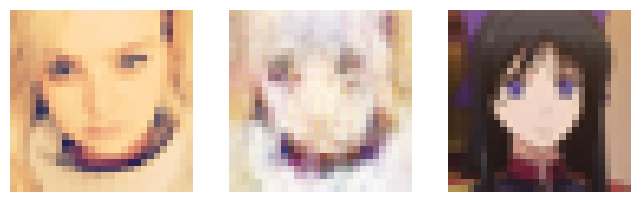

Epoch 1/1:  65%|██████████████████████████▌              | 2201/3400 [08:07<03:51,  5.18it/s, loss_D=1.02, loss_G=3.74]

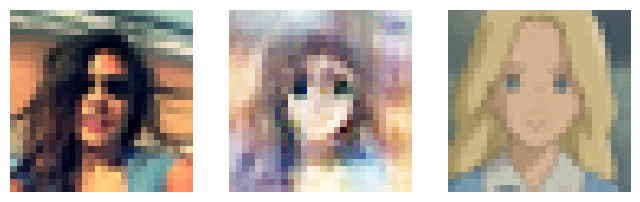

Epoch 1/1:  68%|███████████████████████████             | 2301/3400 [08:27<03:32,  5.17it/s, loss_D=0.301, loss_G=2.57]

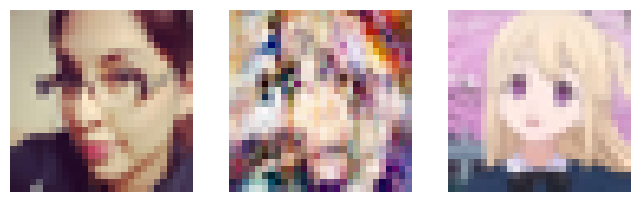

Epoch 1/1:  71%|████████████████████████████▉            | 2401/3400 [08:46<03:17,  5.06it/s, loss_D=1.05, loss_G=3.11]

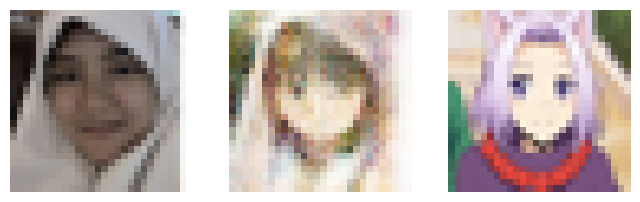

Epoch 1/1:  74%|██████████████████████████████▏          | 2501/3400 [09:06<02:55,  5.12it/s, loss_D=1.15, loss_G=4.61]

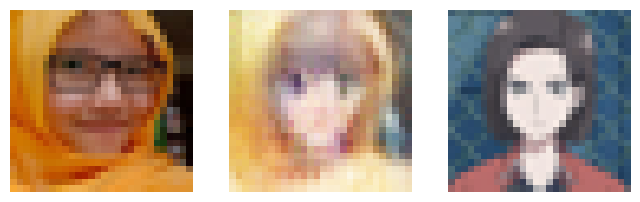

Epoch 1/1:  76%|██████████████████████████████▌         | 2601/3400 [09:26<02:33,  5.19it/s, loss_D=0.811, loss_G=3.37]

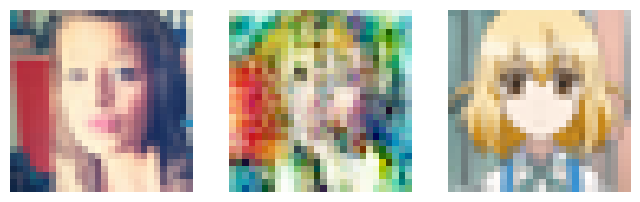

Epoch 1/1:  79%|███████████████████████████████▊        | 2701/3400 [09:48<02:45,  4.23it/s, loss_D=0.856, loss_G=4.02]

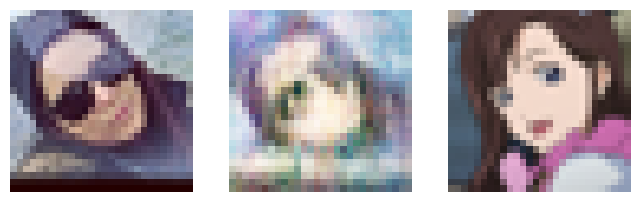

Epoch 1/1:  82%|████████████████████████████████▉       | 2801/3400 [10:11<02:07,  4.68it/s, loss_D=0.376, loss_G=3.78]

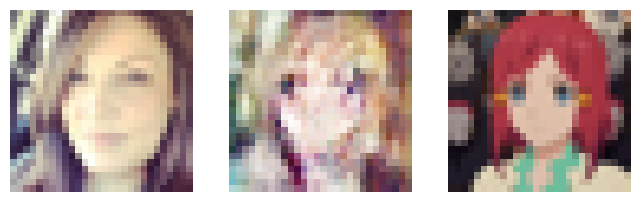

Epoch 1/1:  85%|██████████████████████████████████▏     | 2901/3400 [10:32<01:38,  5.06it/s, loss_D=0.784, loss_G=5.26]

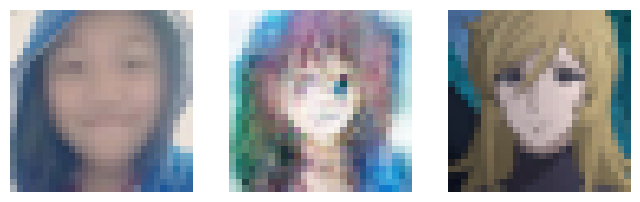

Epoch 1/1:  88%|███████████████████████████████████▎    | 3001/3400 [10:52<01:24,  4.71it/s, loss_D=0.826, loss_G=3.32]

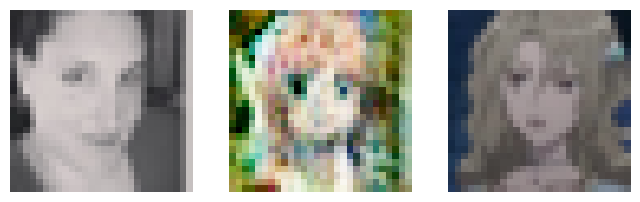

Epoch 1/1:  91%|████████████████████████████████████▍   | 3101/3400 [11:12<00:57,  5.22it/s, loss_D=0.521, loss_G=4.15]

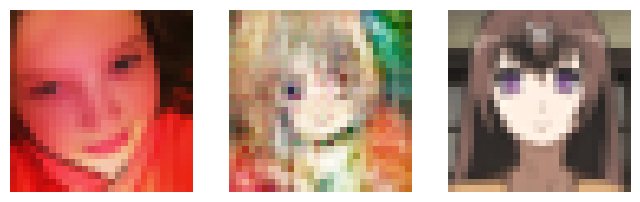

Epoch 1/1:  94%|█████████████████████████████████████▋  | 3201/3400 [11:32<00:39,  5.10it/s, loss_D=0.268, loss_G=3.75]

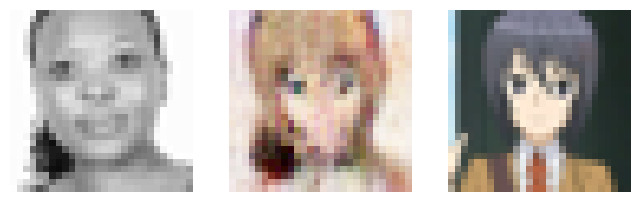

Epoch 1/1:  97%|██████████████████████████████████████▊ | 3301/3400 [11:52<00:20,  4.81it/s, loss_D=0.685, loss_G=3.62]

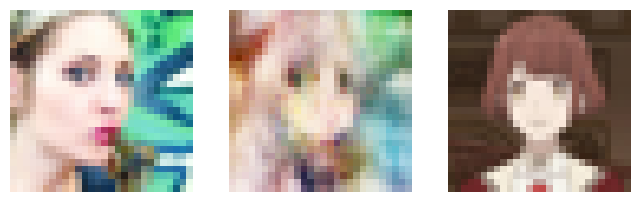

Epoch 1/1: 100%|████████████████████████████████████████| 3400/3400 [12:12<00:00,  4.64it/s, loss_D=0.687, loss_G=2.89]


model has been saved to ./weights\model.pth


In [18]:
import argparse
from torch import optim
from tqdm import tqdm
from torch import nn

# Create an argument parser for the CycleGAN-Pytorch application
parser = argparse.ArgumentParser("CycleGAN-Pytorch")

# Define command-line arguments with their default values and types
parser.add_argument("--root", type=str, default="./imgs", 
                    help="Root directory for the input images")
parser.add_argument("--id", type=int, default=1, 
                    help="Identifier for the experiment")
parser.add_argument("--bs", type=int, default=1, 
                    help="Batch size for training")
parser.add_argument("--lr", type=float, default=1e-4, 
                    help="Learning rate for the optimizer")
                    help="Number of epochs for training")
parser.add_argument("--input_shape", type=int, default=28, 
                    help="Input shape for the images")
parser.add_argument("--p", type=float, default=0.5, 
                    help="Probability for image augmentation (e.g., flipping)")
parser.add_argument("--save_dir", type=str, default="./weights", 
                    help="Directory to save model weights")
parser.add_argument("--pretrain", type=bool, default=True, 
                    help="Flag to indicate if a pretrained model should be loaded")
parser.add_argument("--model_dir", type=str, default="./weights/model.pth", 
                    help="Path to the pretrained model file")
parser.add_argument("--logs_path", type=str, default="./logs", 
                    help="Directory to save training logs")
parser.add_argument("--exp_name", type=str, default="f2m", 
                    help="Experiment name for logging")

# Parse the arguments, and keep only the first parsed set (ignoring any unknown arguments)
opt = parser.parse_known_args()[0]

# Start the training process with the parsed options
train(opt)

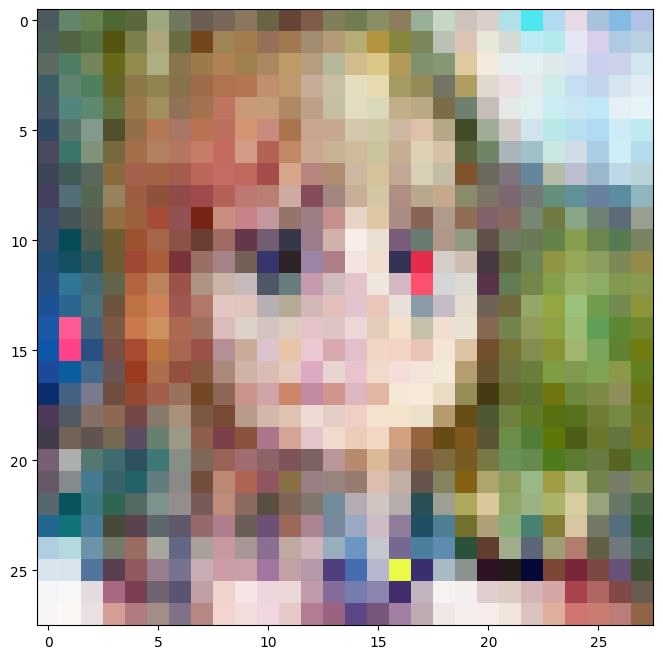

In [20]:
# Open and resize the input image to 28x28 pixels, maintaining aspect ratio
image = ImageOps.fit(Image.open("./imgs/trainA/female_1647.jpg"), (28, 28))

# Get the width and height of the resized image
w, h = image.size

# Load the pretrained model weights from the specified file
ckpt = torch.load("./weights/model.pth")

# Initialize the Generator model
model = Generator()

# Load the weights for the generator from the checkpoint
model.load_state_dict(ckpt["G1"])

# Set the model to evaluation mode
model.eval()

# Convert the image to a tensor and add a batch dimension
img = transforms.ToTensor()(image)[None]

# Disable gradient calculations for inference
with torch.no_grad():
    # Pass the input image through the generator to get the output
    output = model(img)[0]

# Transpose the output tensor to change the shape from (C, H, W) to (H, W, C)
output = np.transpose(output.cpu().clone().numpy(), (1, 2, 0))

# Scale the output to the range [0, 255] and convert it to uint8 format for image representation
image = (output * 255.0).astype(np.uint8)

# Create a PIL image from the numpy array
image = Image.fromarray(image)

# Resize the output image back to the original dimensions
image = ImageOps.fit(image, (w, h))

# Create a figure for displaying the image
figure = plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()
